# Blackjack strategy - geneticly modified
- I have chosen to write a genetic algorithm for strategy optimization in Blackjack. 
- In this iteration the strategy will be only hit(1) or stay(0), no further options (double, split, surrender) are considered. 
    - The strategy can thus be represented by a boolean vector with the right encoding of card value pairs (dealer,player)->(natural number, position in the strategy vector). 
    - The strategy matrix that is considered is a cartesian product of relevant (meaning that the next action of the plyer is not evident, sum 5 -> sure hit) vectors of the player (10,11,...,20) and the dealer (A,2,3,4,5,6,...,10) 
    - The 1/11 value of A does not need to be considered in the matrix, it will be accounted for in the fitness function (but it is not now). 
    
### Please find a complete summary of the project at the bottom of the notebook 

In [1]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
import random
from tqdm.notebook import tqdm
import seaborn as sns
from IPython.display import Image


In [2]:
class Cards(Enum):
    Two = 2
    Three = 3
    Four = 4
    Five = 5 
    Six = 6
    Seven = 7 
    Eight = 8 
    Nine = 9 
    Ten = 10 
    Jack = 10 
    Queen = 10
    King = 10
    Ace = 11

In [3]:
class Strategy: 
    
    def __init__(self, binary_list):
        self.binary_rep = binary_list
        self.matrix_rep = self.get_matrix()
    
    def get_matrix(self):
        if(len(self.binary_rep)!=110):
            print("Error, wrong size of binary_list")
        m = np.mat(self.binary_rep)
        return(m.reshape(11,10))
    
    def visualize_matrix(self, title="Strategy"):

        colors = ['yellow', 'red']
        cmap = mpl.colors.ListedColormap(colors)
        
        fig, ax = plt.subplots()
        im = ax.imshow(self.matrix_rep, cmap=cmap)

        x = ['2', '3', '4', '5','6', '7', '8', '9','10','A']
        y = ['10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20']

        ax.set_xticks(np.arange(len(x)))
        ax.set_yticks(np.arange(len(y)))

        ax.set_xticklabels(x)
        ax.set_yticklabels(y)
        
        plt.xlabel("Dealer's card")
        plt.ylabel("Player's cards sum")

        for i in range(len(x)):
            for j in range(len(y)):
                text = ax.text(i, j, "S" if self.matrix_rep[j,i]<0.5 else "H",ha="center", va="center", color="b")

        ax.set_title(title)

        plt.show()

### Optimal strategy as its generally known 
- See https://wizardofodds.com/games/blackjack/strategy/4-decks/

In [4]:
def get_optimal_strategy():
    s_optimal_vec = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return Strategy(s_optimal_vec)

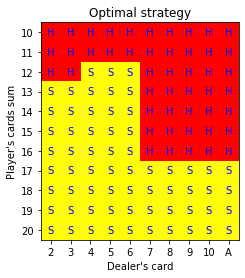

In [5]:
s_optimal = get_optimal_strategy()
s_optimal.visualize_matrix("Optimal strategy")

### Optimal strategy as an input from expert

In [6]:
def get_expert_strategy():
    s_expert_vec = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return Strategy(s_expert_vec)

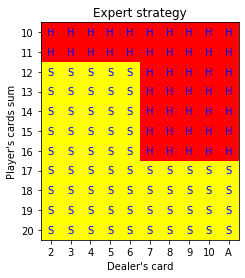

In [7]:
s_expert = get_expert_strategy()
s_expert.visualize_matrix("Expert strategy")

### Binary representation - meaning
- Take the matrix a_(1,1) = (10,2) a_(1,2) = (10,3)... a_(1,10) = (10,A) ... a_(11,1) = (20,2) ... a_(11,10) = (20,A)
- And create vector from it by giving row after row. 

In [8]:
s1 = [1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,1,1]

# Simulating the game 
- Shuffle the deck, take a strategy and play. Return the amount of money that the player won. 

In [9]:
def get_shuffled_shoe(decks):
    shoe = []
    for i in range(decks*4):
        for name, value in Cards.__members__.items():
            shoe.append(value)
    shuffled_shoe = shuffle(shoe)
    return shoe

In [10]:
def get_shuffled_shoe_seeded(decks,seed):
    random.seed(seed)
    return get_shuffled_shoe(decks)

In [11]:
def play_hand(shoe, strategy):
    dealer_cards = [shoe.pop()]
    player_cards = [shoe.pop(),shoe.pop()]
    
    dealer_sum = dealer_cards[0].value
    player_sum = sum([i.value for i in player_cards])  #TODO adjust for soft Aces. 
    
    while player_sum<21:
        if player_sum<10:
            player_cards.append(shoe.pop())
            player_sum = sum([i.value for i in player_cards])
        else:
            if(strategy.matrix_rep[player_sum-10, dealer_sum-2]==1):
                player_cards.append(shoe.pop())
                player_sum = sum([i.value for i in player_cards])  
            else:
                break
    
    while dealer_sum<17 and player_sum<22:
        dealer_cards.append(shoe.pop())
        dealer_sum = sum([i.value for i in dealer_cards])

    return player_sum, dealer_sum    

In [12]:
def simulate_game(strategy, rounds, bet_size):
    
    decks = round(rounds/10)+1
    shoe = get_shuffled_shoe_seeded(decks,115) #Seeded or not seeeded, that is the question?
    money = 0
    
    for r in range(rounds):
        player_points, dealer_points = play_hand(shoe,strategy)
        players_gain = evaluate_play_results(player_points, dealer_points, bet_size)
                
        money = money+players_gain
        
    return money

In [13]:
def evaluate_play_results(player_points, dealer_points, bet_size):        #TODO adjust for blackjacks... 
    if player_points>21:
        return -bet_size
    elif dealer_points>21:
        return bet_size
    elif player_points>dealer_points:
        return bet_size
    elif player_points==dealer_points:
        return 0 
    else:
        return -bet_size

In [14]:
simulate_game(s_optimal,5000,50)

-3500

# Genetics 
- Create random population 
    - Get their fitness. 
    - Get statistics - best fitness - worst fitness - median, deciles, variation, save the best strategy. 
    - Create new generation with crossover and mutation functions, compute their fitness and add them to the pool. 
    - Stochastically remove weak players from the pool to a certain value.
    - Repeat until stopping rule (some fitness value, its delta, or number of steps... )
    

In [15]:
def generate_random_population(pop_size):
    pop = []
    for i in (range(pop_size)):
        pop.append(Strategy(np.random.randint(2, size=110)))
    return pop

In [16]:
class Statistics: 
    it_number = 0
    max_values = []
    min_values = []
    means = []
    stds = []
    decils = []
    top_strategies = []

    def __init__(self):
        self.it_number = 0
        self.max_values = []
        self.min_values = []
        self.means = []
        self.stds = []
        self.decils = []
        self.top_strategies = []

In [17]:
def stopping_rule(_type,value, threshold):
    return rules(_type)(value, threshold)  

In [18]:
def rules(argument): 
    switcher = { 
        0: lambda x,threshold : x <threshold, 
        1: lambda y :print("Unknown rule:1")
    } 
    return switcher.get(argument, "nothing") 

In [19]:
def update_stats(stats, pop, rounds, bet_size=50 ):
    
    fitness = []
    
    for i in tqdm(range(len(pop)), 'Player playing'):
        
        fitness.append(simulate_game(pop[i], rounds, bet_size))
        
    stats.it_number = stats.it_number+1
    stats.max_values.append(max(fitness))
    stats.min_values.append(min(fitness))
    stats.means.append(np.mean(fitness))
    stats.stds.append(np.std(fitness))
    stats.decils.append(np.percentile(fitness, np.arange(0, 100, 10)))
    stats.top_strategies.append(pop[fitness.index(max(fitness))])
    
    return(stats)

In [20]:
def get_fitness_for_removal(pop,rounds,bet_size = 50):
    fitness = []
    
    for player in pop: 
        fitness.append(simulate_game(player, rounds, bet_size))
        
    return fitness

### Crossover
- For now the crossover is single point crossover between randomly created pairs of players. 
- Proposed generalizations
    - Players with better fitness mate with other fit players. Plus they have more children than the unfit ones. 
    - k-fold crossover. 
    

In [21]:
def add_crossover(pop): 
    pop1 = random.sample(pop,round(len(pop)/2))
    pop2 = list(set(pop) - set(pop1))
    
    for i in range((round(len(pop)/2-1))):
        first_genom = pop1[i].binary_rep
        second_genom = pop2[i].binary_rep
        k = random.randrange(10,100)
        first_part = first_genom[:k]
        second_part = second_genom[k:]
        child_genom = np.concatenate([first_part, second_part])
        pop.append(Strategy(child_genom))

    return pop

In [22]:
def add_mutants(pop, mutation_rate):
    new_pop = pop.copy()
    for player in pop: 
        change = np.random.choice([0, 1], size=(110,), p=[1-mutation_rate,mutation_rate])
        mutated_binary_rep = player.binary_rep.copy()
        for i in np.where(change==1)[0]:
            mutated_binary_rep[i] = 1- mutated_binary_rep[i]
            
        new_pop.append(Strategy(mutated_binary_rep))
        
    return new_pop 

In [23]:
def get_deadly_pdf(N, lucky_factor):
    x = np.linspace(0,lucky_factor,N)
    pdf = np.exp(-x**2/2)/np.sqrt(2*np.pi)
    pdf = pdf/np.sum(pdf)
   # print("Plotting your deadly pdf")
   # plt.plot(pdf)
    return pdf

In [24]:
def sort_pop(pop, fitness):
    pop = np.array(pop)
    ages = np.array(fitness)
    inds = ages.argsort()
    return pop[inds]

In [25]:
def remove_the_weak(pop,lucky_factor, fitness, pop_size):
    
    sorted_pop = sort_pop(pop,fitness)
    
    N = len(pop)
    n = len(pop)-pop_size
    pdf = get_deadly_pdf(N,3)
    x = np.linspace(0,1,N)
    indices = np.full(x.shape, False, bool)
    randices = np.random.choice(np.arange(indices.shape[0]), n, replace = False,p = pdf)
    indices[randices] = True
   # print(indices)
    remaining_population = np.array(sorted_pop)[~indices]
    
    return remaining_population.tolist()

In [26]:
def complete_simulation(pop_size,iterations, stopping_rule_type, rounds): 
    stats = Statistics()
    pop = generate_random_population(pop_size)
    _continue = stopping_rule(stopping_rule_type,stats.it_number,iterations)
 
    while _continue:
        print("Iteration: "+str(stats.it_number))
        stats = update_stats(stats, pop, rounds)
        pop = add_crossover(pop)
        pop = add_mutants(pop,0.05)     # Maybe adding the mutants instead of replacing is not standard  

        fitness_for_removal = get_fitness_for_removal(pop,rounds)
        pop = remove_the_weak(pop,3, fitness_for_removal, pop_size)

        _continue = stopping_rule(stopping_rule_type,stats.it_number,iterations)
        
    return stats 

### Random shooting
- I dont know where to go (Shoot and go) with the matrix, so I will just shoot. 
- To compare somewhat reasonably the GA to SG, one has to have the same amount of Players generated, in case of population of 100 and 100 generations -> 10k players emerge. 

In [27]:
def random_shooting_simulation(pop_size, iterations, rounds):  
    pop = generate_random_population(pop_size*iterations)
    stats = Statistics()
    stats = update_stats(stats,pop, rounds)
    
    return stats

In [28]:
pop_size = 100
iterations = 150
stopping_rule_type = 0 # 0 - "number of iterations"
rounds = 2000
bet_size = 50

In [29]:
stats_GA = complete_simulation(pop_size, iterations, stopping_rule_type, rounds)

Iteration: 0



Iteration: 1



Iteration: 2



Iteration: 3



Iteration: 4



Iteration: 5



Iteration: 6



Iteration: 7



Iteration: 8



Iteration: 9



Iteration: 10



Iteration: 11



Iteration: 12



Iteration: 13



Iteration: 14



Iteration: 15



Iteration: 16



Iteration: 17



Iteration: 18



Iteration: 19



Iteration: 20



Iteration: 21



Iteration: 22



Iteration: 23



Iteration: 24



Iteration: 25



Iteration: 26



Iteration: 27



Iteration: 28



Iteration: 29



Iteration: 30



Iteration: 31



Iteration: 32



Iteration: 33



Iteration: 34



Iteration: 35



Iteration: 36



Iteration: 37



Iteration: 38



Iteration: 39



Iteration: 40



Iteration: 41



Iteration: 42



Iteration: 43



Iteration: 44



Iteration: 45



Iteration: 46



Iteration: 47



Iteration: 48



Iteration: 49



Iteration: 50



Iteration: 51



Iteration: 52



Iteration: 53



Iteration: 54



Iteration: 55



Iteration: 56



Iteration: 57



Iteration: 58



Iteration: 59



Iteration: 60



Iteration: 61



Iteration: 62



Iteration: 63



Iteration: 64



Iteration: 65



Iteration: 66



Iteration: 67



Iteration: 68



Iteration: 69



Iteration: 70



Iteration: 71



Iteration: 72



Iteration: 73



Iteration: 74



Iteration: 75



Iteration: 76



Iteration: 77



Iteration: 78



Iteration: 79



Iteration: 80



Iteration: 81



Iteration: 82



Iteration: 83



Iteration: 84



Iteration: 85



Iteration: 86



Iteration: 87



Iteration: 88



Iteration: 89



Iteration: 90



Iteration: 91



Iteration: 92



Iteration: 93



Iteration: 94



Iteration: 95



Iteration: 96



Iteration: 97



Iteration: 98



Iteration: 99



Iteration: 100



Iteration: 101



Iteration: 102



Iteration: 103



Iteration: 104



Iteration: 105



Iteration: 106



Iteration: 107



Iteration: 108



Iteration: 109



Iteration: 110



Iteration: 111



Iteration: 112



Iteration: 113



Iteration: 114



Iteration: 115



Iteration: 116



Iteration: 117



Iteration: 118



Iteration: 119



Iteration: 120



Iteration: 121



Iteration: 122



Iteration: 123



Iteration: 124



Iteration: 125



Iteration: 126



Iteration: 127



Iteration: 128



Iteration: 129



Iteration: 130



Iteration: 131



Iteration: 132



Iteration: 133



Iteration: 134



Iteration: 135



Iteration: 136



Iteration: 137



Iteration: 138



Iteration: 139



Iteration: 140



Iteration: 141



Iteration: 142



Iteration: 143



Iteration: 144



Iteration: 145



Iteration: 146



Iteration: 147



Iteration: 148



Iteration: 149


In [30]:
stats_RS = random_shooting_simulation(pop_size, iterations, rounds)
RS_result=stats_RS.max_values[0]
RS_result

-16550

In [31]:
expert_result = simulate_game(s_expert, rounds, bet_size)
expert_result

-4900

In [32]:
optimal_result = simulate_game(s_optimal, rounds, bet_size)
optimal_result

-4450

## Strategy comparison
- In the following cell we examine the evolution of a GA in the simulation. 

Graphical representation
- Black dots represent fitness function result for the best individuals in the generation with its number on x axis. 
- y axis represents value of a fitness function, money that was earned through the gameplay.
- Yellow dots represent mean value of a fitness function in a generation. 
- Red line is the best result from a set of random generated population, with no evolution and a population size equal to the number of individuals in GA times the number of generations in GA. This number is chosen to more logically compare the results. 
- Blue and black lines are results of the expert and optimal strategies presented in the beginning of this notebook. 

Genetics
- We can see that genetic results are really bad in the beginning, but they have good trend. The algorithm is able to "learn" the shoe (in the current implementation consisting of approaximately 10k cards) and become profitable around a generation 37. 
- The evolution has its limits and we can see that there is only small change from the best result of 70th generation and the 150th.

What next
- A deeper study of parameter changes and optimal strategy could certainly be done in the future. The same way as a study of sudden jumps in performance, in other words, what happened in the iteration xy and why it is important for better fitness? 

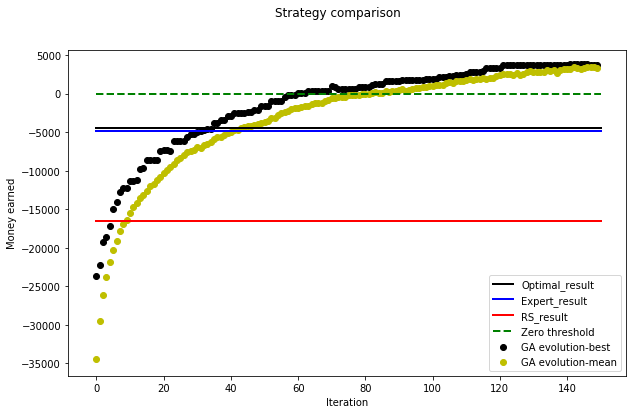

In [33]:
y = stats_GA.max_values
x = range(iterations)
y_2 = stats_GA.means

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y, c='k', label = "GA evolution-best")
ax.scatter(x,y_2,c = 'y', label = "GA evolution-mean")
ax.plot([0, iterations],[optimal_result, optimal_result], 'k-', lw=2,label =  "Optimal_result")
ax.plot([0, iterations],[expert_result, expert_result], 'b', lw=2, label = "Expert_result")
ax.plot([0, iterations],[RS_result, RS_result], 'r', lw=2, label = "RS_result")
ax.plot([0, iterations],[0, 0], 'g--', lw=2, label = "Zero threshold")



fig.suptitle("Strategy comparison")
plt.ylabel("Money earned")
plt.xlabel("Iteration")
plt.legend()
plt.show()

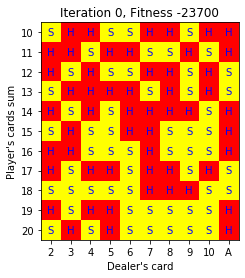

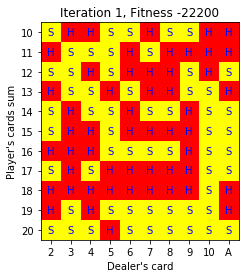

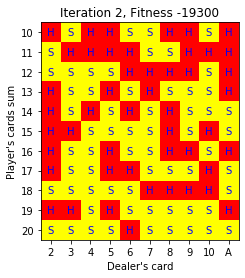

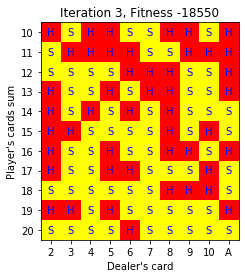

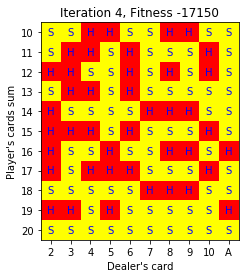

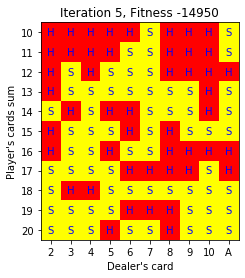

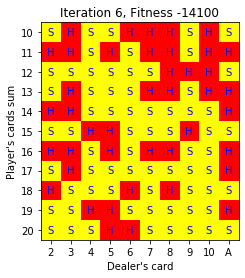

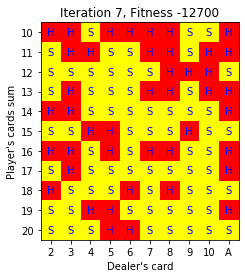

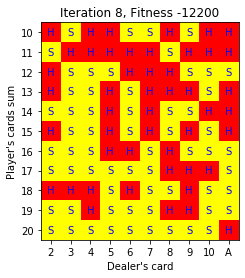

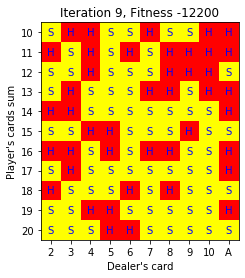

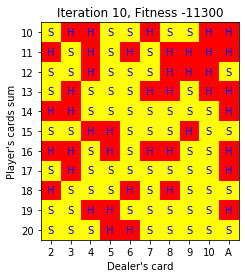

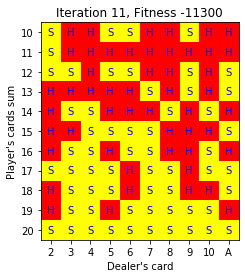

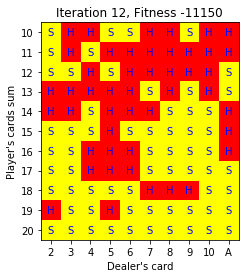

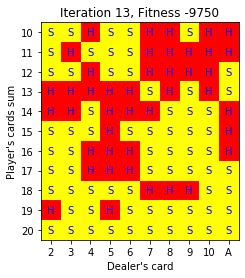

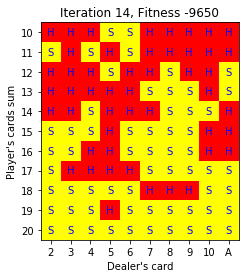

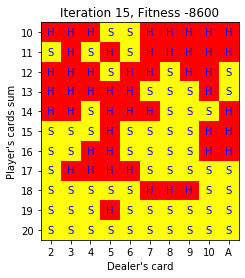

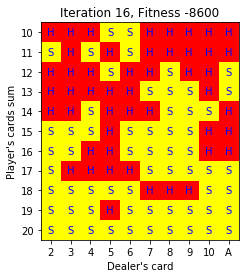

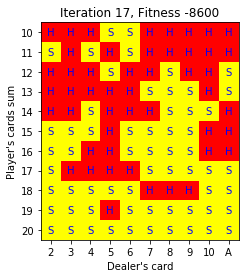

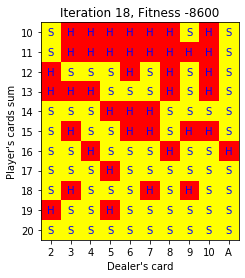

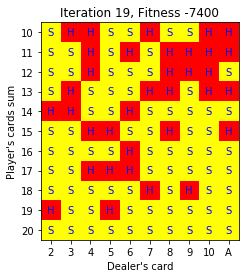

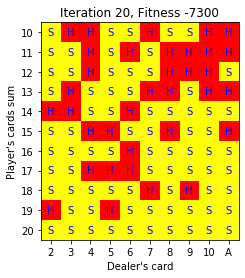

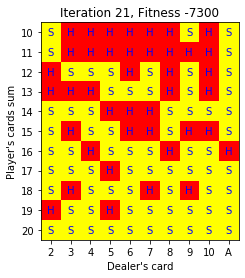

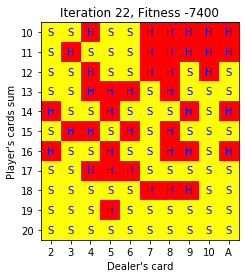

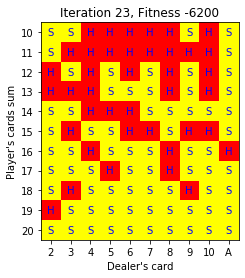

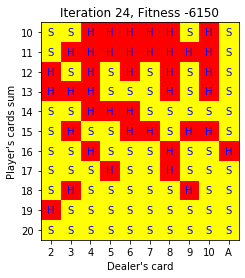

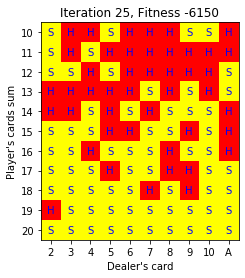

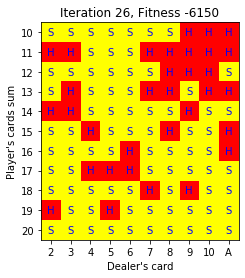

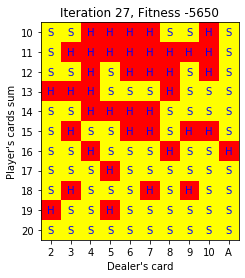

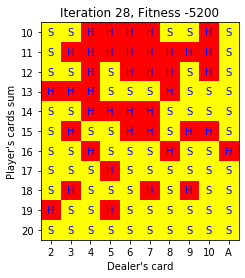

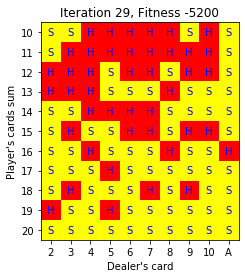

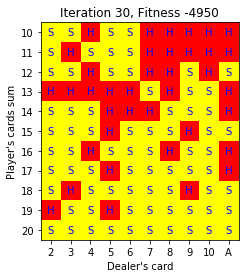

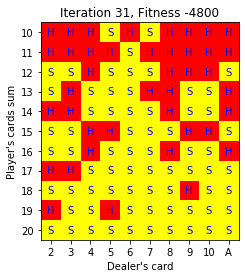

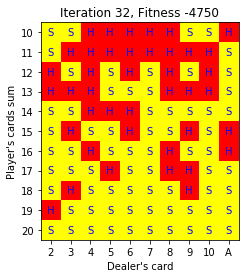

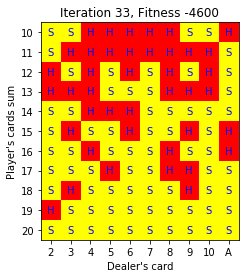

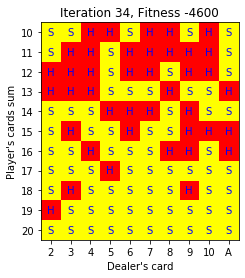

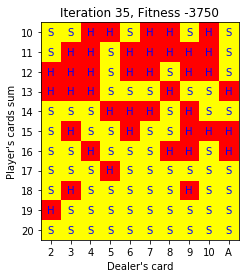

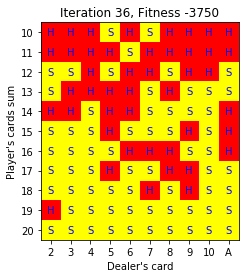

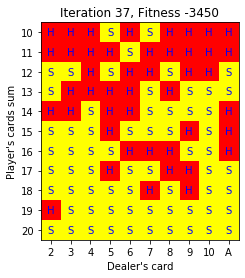

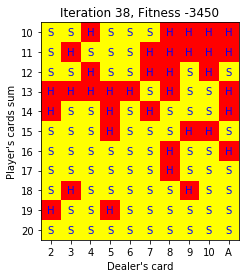

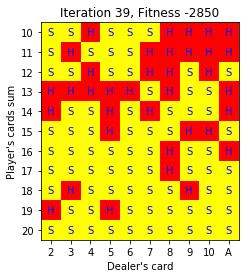

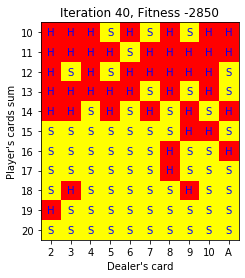

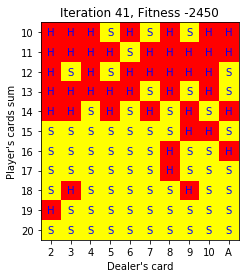

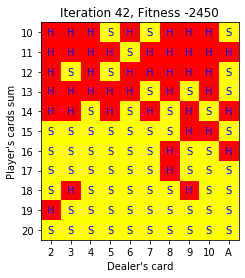

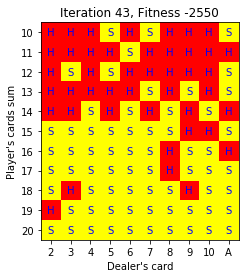

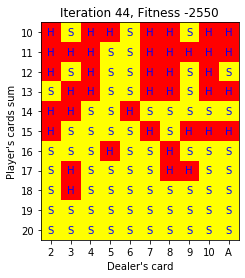

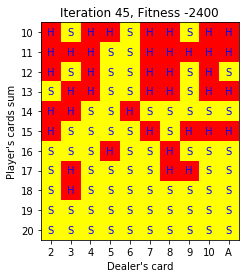

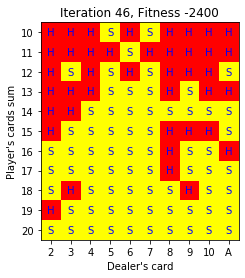

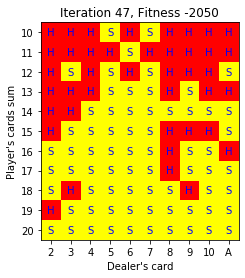

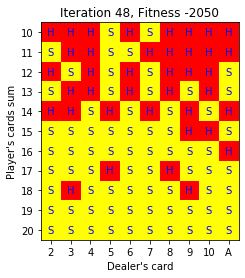

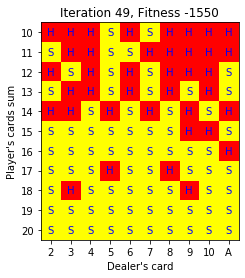

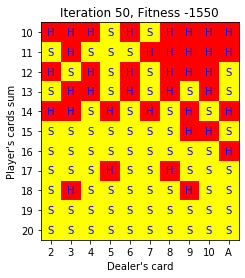

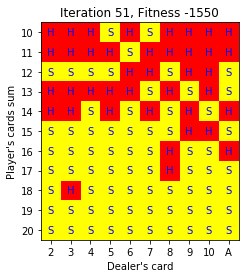

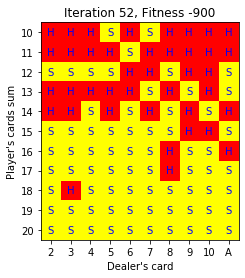

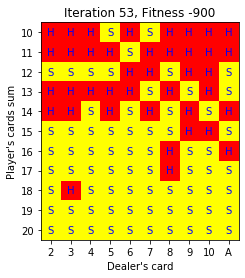

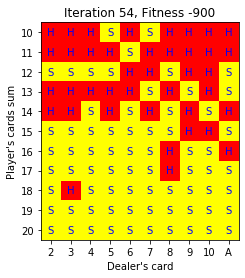

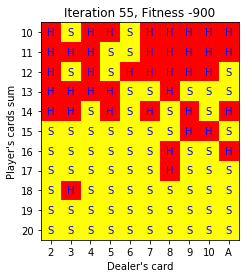

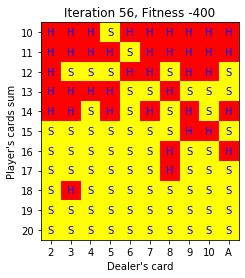

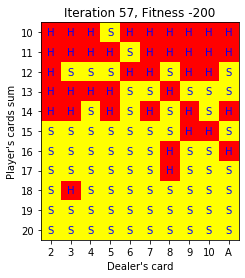

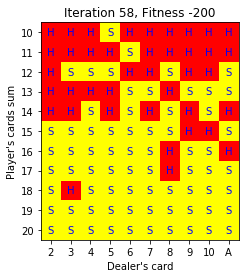

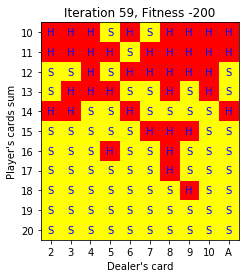

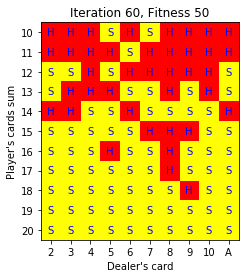

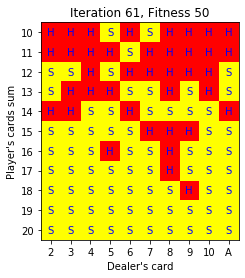

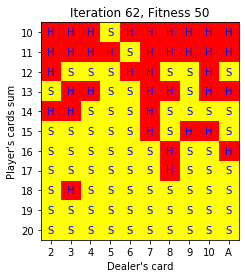

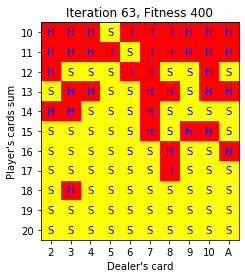

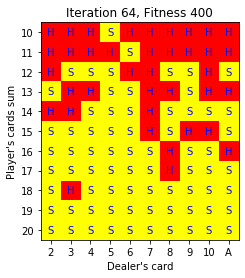

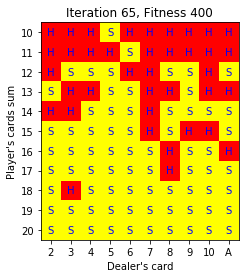

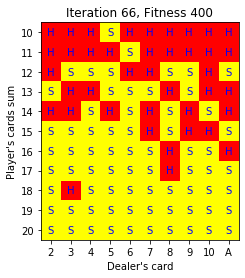

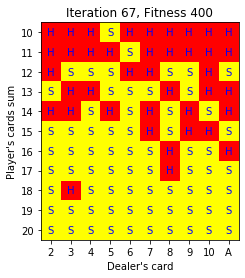

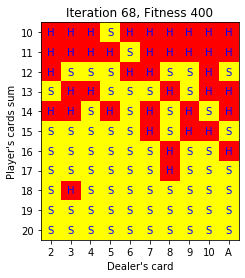

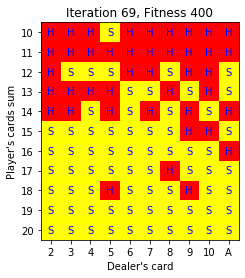

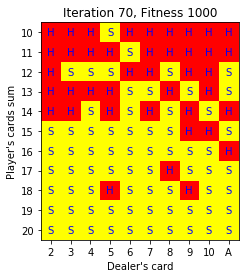

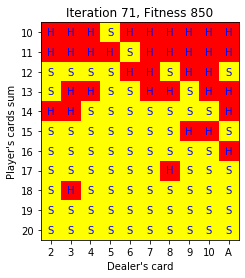

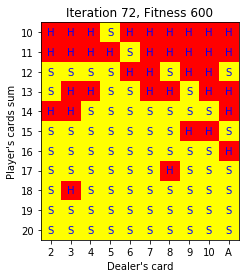

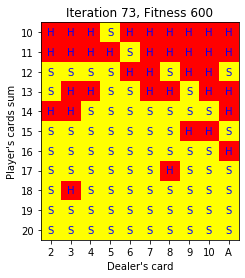

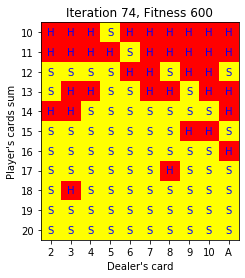

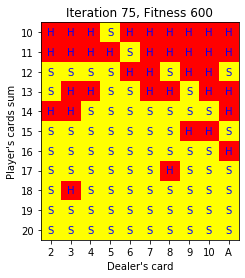

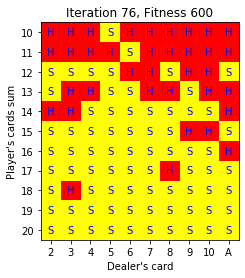

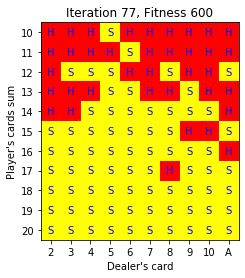

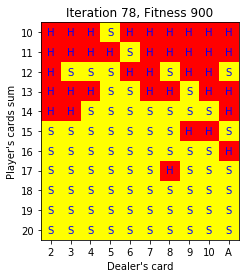

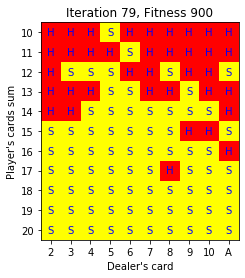

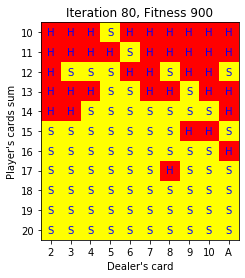

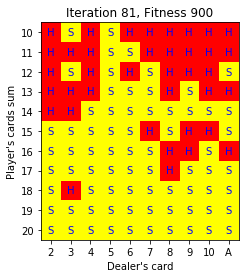

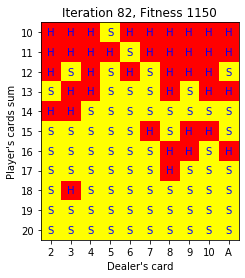

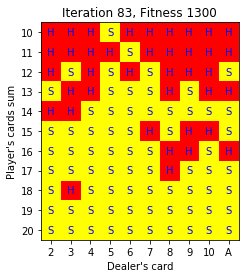

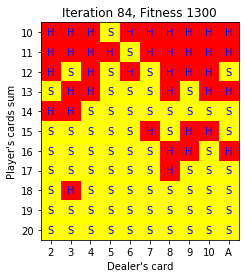

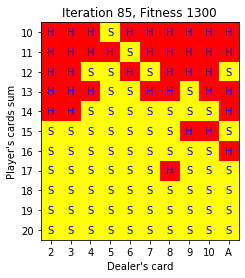

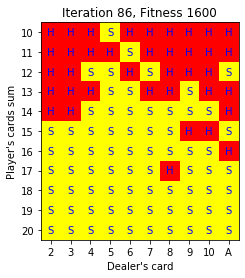

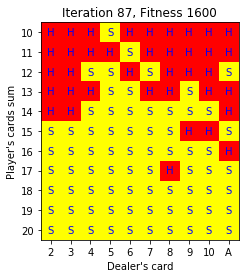

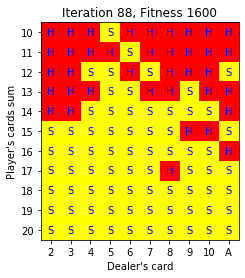

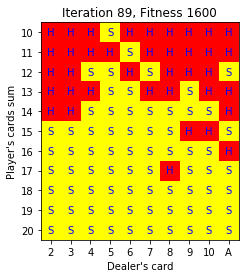

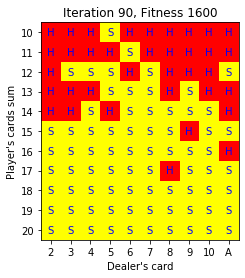

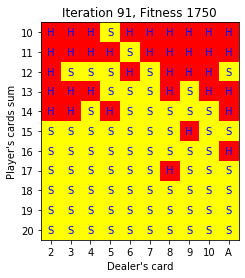

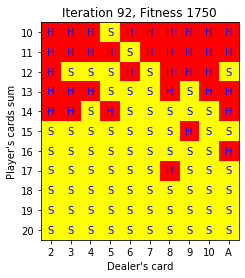

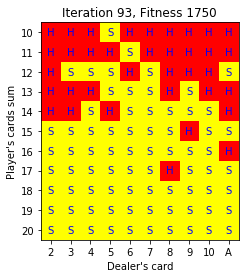

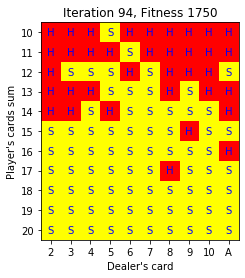

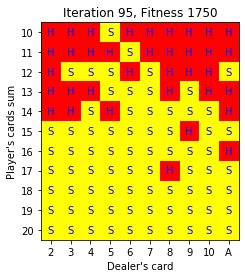

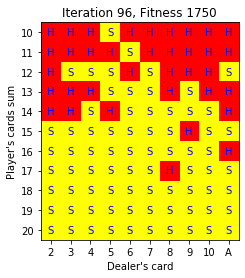

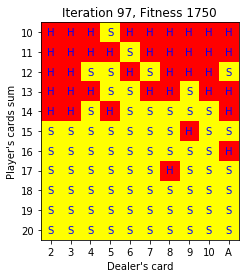

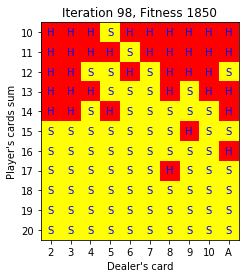

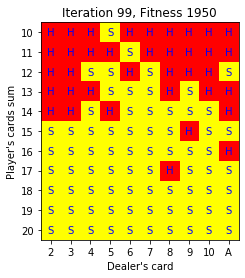

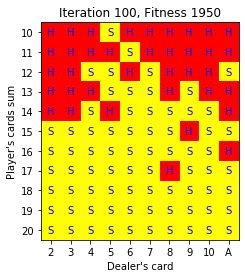

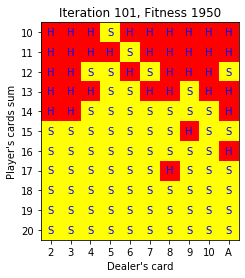

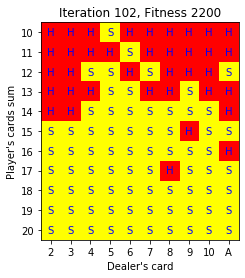

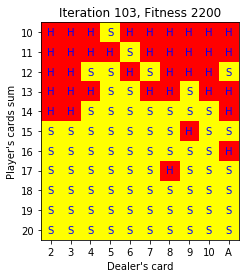

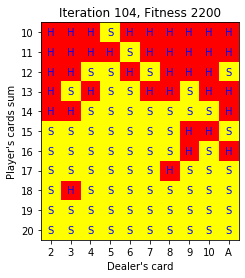

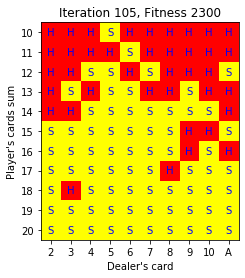

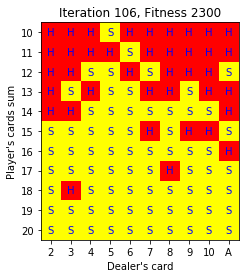

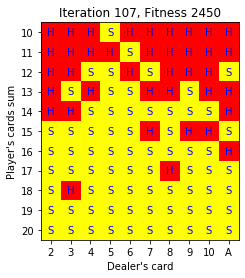

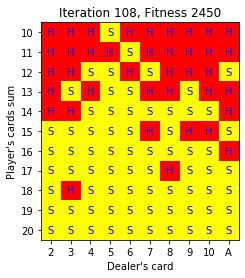

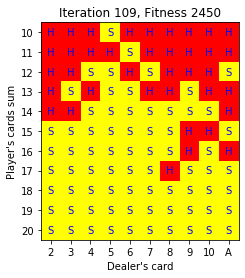

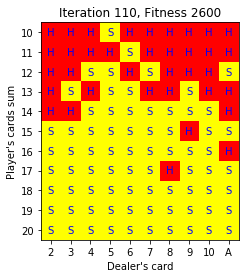

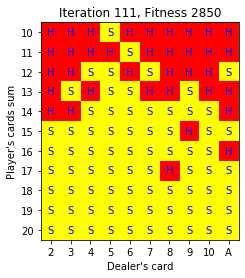

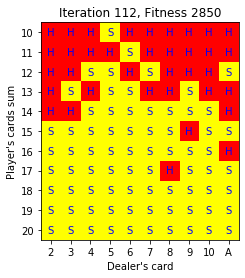

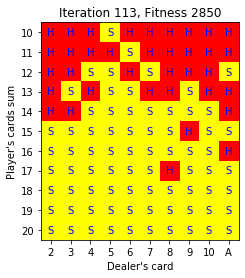

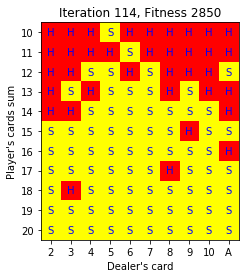

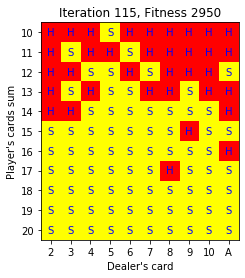

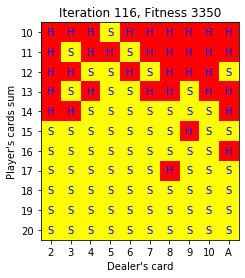

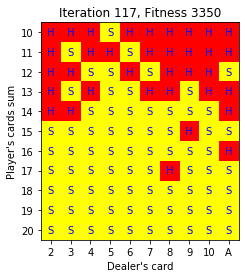

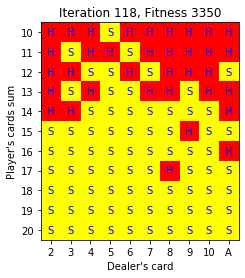

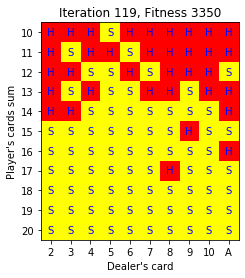

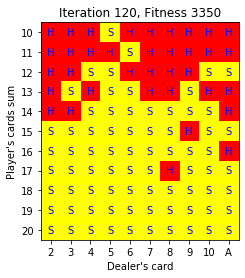

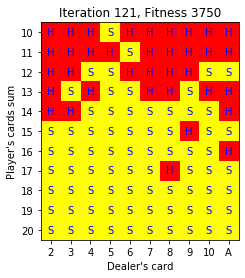

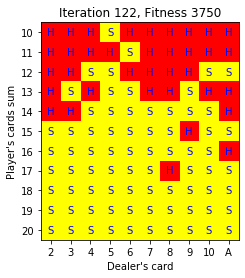

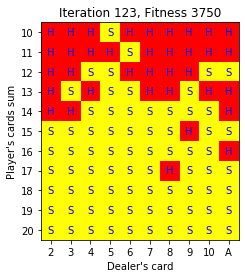

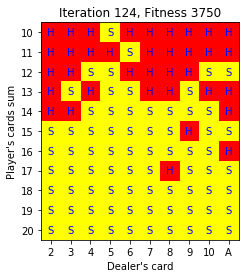

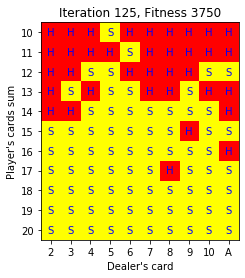

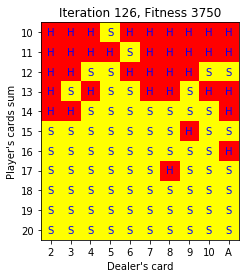

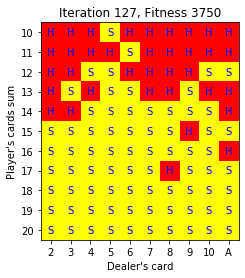

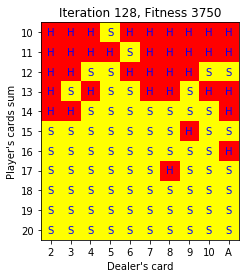

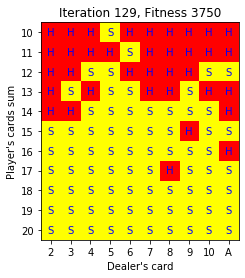

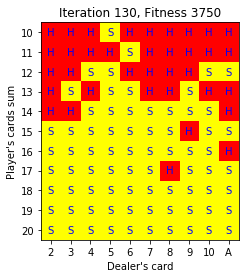

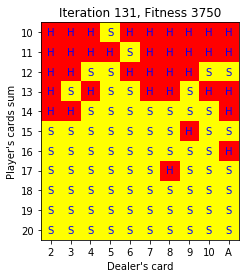

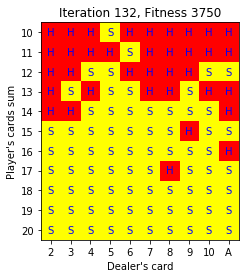

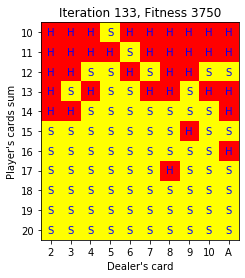

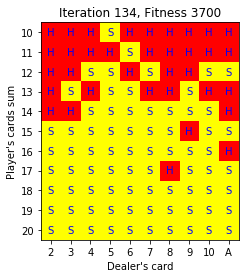

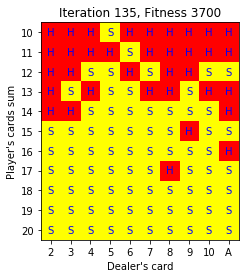

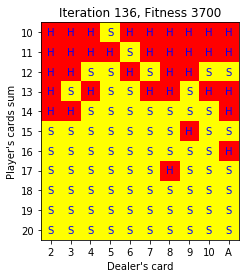

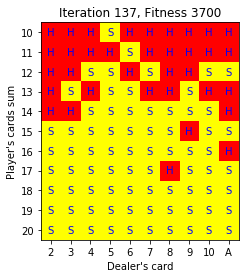

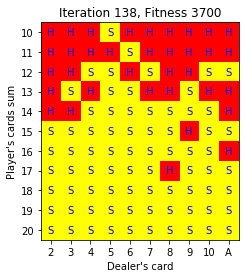

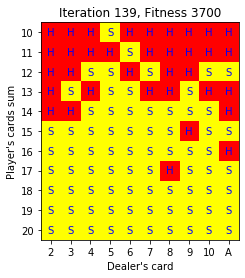

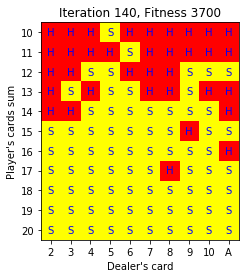

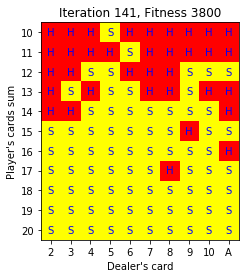

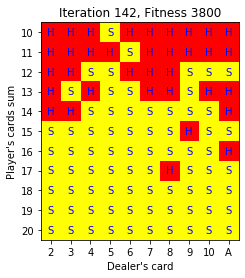

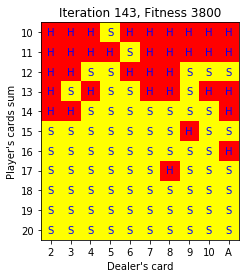

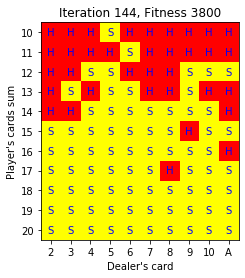

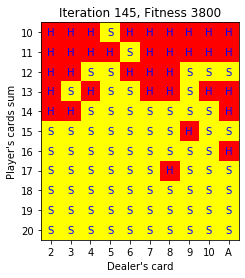

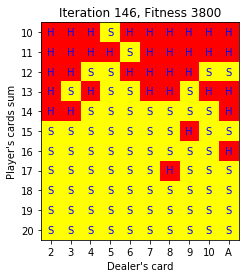

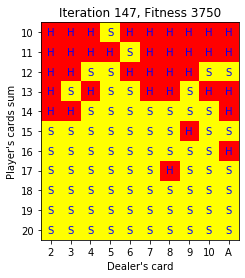

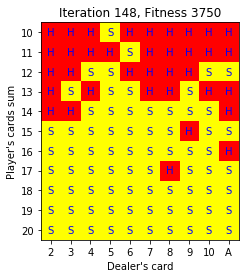

In [34]:
for i in range(iterations-1):
    stats_GA.top_strategies[i+1].visualize_matrix("Iteration "+str(i)+ ", Fitness "+ str(stats_GA.max_values[i]))

### HeatMap
- In the end the heatmap does not say much, because the strategies tend to not change in the later phases of the evolution. 
- Light spaces say hit, dark say stay. 
- We can see that even though it should not be optimal to stay at 10 if dealer has a 5, most of the strategies actually do this.
- This migh mean that the seeded package is exceptional in some sense, that in games where player has 10 and potentialy takes a card that would be bad for the dealer.  
- Or it might not be that way and the mutation just never hits this part of the genom.
- As the evolution is influenced by a random mutations the heatmap is different each time. 


Text(33.0, 0.5, "Player's cards sum")

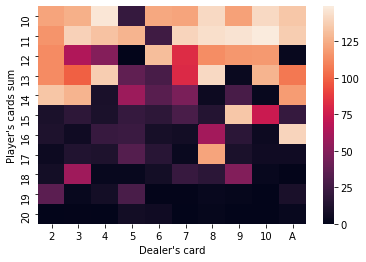

In [35]:
sum_of_mats = np.zeros((11,10))
for strat in stats_GA.top_strategies:
    matrix = strat.get_matrix()
    sum_of_mats = sum_of_mats +matrix
    
x = ['2', '3', '4', '5','6', '7', '8', '9','10','A']
y = ['10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20']

heat_map = sns.heatmap(sum_of_mats, xticklabels = x, yticklabels = y)

plt.xlabel("Dealer's card")
plt.ylabel("Player's cards sum")

# Overview of the work

## Idea 

- The core of this project for 18HEUR subject on FNSPE CTU Prague is to implement genetical algorithm (GA) playing simplified version of a popular card game blackjack. 
- There are no soft aces, no double or split possible. Blackjack pays only double not 5/2 the bet. Dealer hits under 17 always. 
- The game fits the formate of GA nicely. Each strategy can be interpreted as a 110 bits long binary vector, which makes the crossovers and mutation easy to implement. The game is simple enough and its social impact high enough, that it makes sense to study it and try to develop interesting GA and learn something new on it. 

## Execution 
#### Setup 
- First card class and shoe is implemented. Take some number of packages and shuffle them together. 
- Then define a strategy as a 110 bits long vector or a binary matrix 11x10. A visualization of such strategy serves only for better examinaiton of what is going on.
- Define expert strategy (from a friend) and optimal strategy (from the [internet](https://wizardofodds.com/games/blackjack/strategy/4-decks/)). 
- Implement a game simulation, player takes cards according to his bits in his strategy, dealer based on casino rules. 

#### Genetics 
- Now its time for some genetics. First make sure to be able to generate random population. 
- Then crossover, cut tvo individual vectors at some random threshold and glue them together, voila new strategy. 
- Mutation is also simple, just with some small chance change each bit separatelly. 
- Finally, delete the weak individuals. But not simply like only take the first 100, but give a chance to the poor performers to be lucky. A deadly pdf tells the destiny of each individual in a population. 

#### Simulation 
- Generate random population, breed new individuals, create mutants, remove the weak and repeat, for example 150 times. And now you have a champion (hopefully). 

## Results 
- From the graphs above, it can be seen that GA performance is week from the start, which makes sense. 
- It also improves is fitness function rapidly from the beginning, which is again a good sign for GAs. 
- Then a classic slowdown occurs, there is not much more space to evolve and we are reaching local (or global) maxima of the fitness function. 
- Everything works well according to GA framework. We could play with parameters and study speed of convergence, but that is out of the scope of this work. 

## Conclusion
- Random fitness function is a problem. The unrealistic assumption of seeded shoe bothers me. 
- I do not really know how to handle random fitness funcitons in GA. 
- Otherwise GA proved itsef to be a cool optimization method. It is not that complicated to implement and its results can be very good in comparison to random shooting or not knowing what better thing to do with such problem. 
- Blackjack could be, and probably was solved theoretically, but this seems as more fun than compute probability distributions of the next cards by classical game theory. Classical game theory would probably give better results. 

## What could be done but was not
- Real blackjack has splits, doubling, surrender, blackjack paying 5/2, insurances, soft aces. 
- Card counting could be implemented, however the more shuffled decks the shoe has, the lower the advantage I guess. 
- Crossover could be more complicated, not only one cut. 
- Best representant of a population could be chosen as the majority vote from top 20% of strategies for example. 
- Crossover that is a majority voting from multiple good strategies, that could be fun. 
- New metrics, distance from the optimal strategy. 
- Visualisation of decils. 
- Values 8,9,21 could be added to the matrix to mess with the algorithm. 
- Compare the results of strategy trained on fixed deck to the optimum on random decks. 
- Plot iterations where something changed only. 

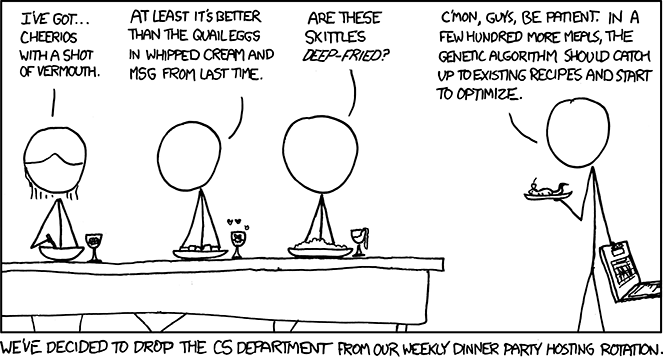

In [36]:
Image(filename='GA_vtip.png') 